# Using  WW3 models to generate $\delta_{rms}(\lambda,\phi)$ for any $(\lambda,\phi)$ pair

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
import os
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import netCDF4
import numpy as np
from scipy import interpolate
import scipy.integrate
from obspy.geodetics.base import gps2dist_azimuth
from obspy import UTCDateTime
from obspy.geodetics.base import kilometer2degrees, locations2degrees
import numpy.matlib


import warnings
warnings.filterwarnings('ignore')


from cartopy import config
import cartopy.crs as ccrs
os.environ["CARTOPY_USER_BACKGROUNDS"] = "BG/"

import ww32seismo
from ww32seismo import *

Import configurations and Settings

In [2]:
import dynamic_yaml
with open("config.yml", 'r') as f:
    configs = dynamic_yaml.load(f)

target = configs.params.station
target_lat = configs.params.station_lat
target_lon = configs.params.station_lon
rhos = configs.params.rhos
beta = configs.params.beta
Rg = configs.params.Rg
Q = configs.params.Q
Re = 4.0e7/(2*np.pi)
depth_file = configs.files.depth

In [3]:
#  needed files: Rayleigh_source.txt, depth file, and 2 models with and without reflection /!\

dataset = netcdf_dataset(r"{}".format(depth_file))
dpt = pd.DataFrame(np.asarray(dataset.variables["dpt"])[50,:,:], columns=dataset.variables["longitude"], index=dataset.variables["latitude"])
dpt[dpt==-32767] *= 0.0
dpt[dpt<=0.0] = 0.0

if not os.path.isdir("DATA"):
    os.mkdir("DATA")
if not os.path.isdir("FIGURES"):
    os.mkdir("FIGURES")    

# Plot depth and distance

In [4]:
lats, lons, distance_df = ww32seismo.get_distance(configs, dataset, dpt, plot=False)

In [5]:
df = pd.read_csv(r"DATA/Rayleigh_source.txt", header=None, delim_whitespace=True, index_col=0)
df.index *= np.pi
df = df.fillna(0.0)
C_base = (df[:8]**2).sum(axis=1)
C_base.at[C_base.index[-1]+0.01] = 0.0
C_base.at[-1.0] = 0.0
C_base.at[20.0] = 0.0
C_base = C_base.sort_index()

Cf = interpolate.interp1d(C_base.index, C_base)

# TEMP

In [6]:
month = 10
beta = configs.params.beta
CgR = configs.params.Rg
target = configs.params.station
factor1, alpha, alpha2 = alpha_distance(configs,Re, distance_df)
fn = os.path.join(configs.files.p2l_dir,"LOPS_WW3-GLOB-30M_2021{}_p2l.nc".format(month))
fname = r"{}".format(fn)
dataset = netcdf_dataset(fname)
lats = dataset.variables['latitude'][:]
lons = dataset.variables['longitude'][:]
times = dataset.variables['time']
times = netCDF4.num2date(times[:],times.units)
freqs = dataset.variables['f'][:] # ocean wave frequency

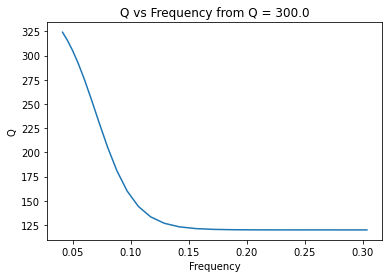

In [7]:
period = False
Qf=(0.4+0.4*(1-np.tanh(15*(2*freqs-0.14))))*Q
plt.figure()
plt.title("Q vs Frequency from Q = {}".format(Q))
if period:
    plt.plot(1/freqs, Qf)
    plt.xlabel("Period (s)")
else:
    plt.plot(freqs, Qf)
    plt.xlabel("Frequency")
plt.ylabel("Q")
plt.show()

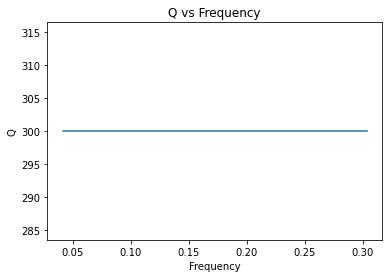

In [8]:
Qf = np.ones(len(freqs)) * Q
plt.figure()
plt.title("Q vs Frequency")
plt.plot(freqs, Qf)
plt.xlabel("Frequency")
plt.ylabel("Q")
plt.show()

In [25]:
from ww32seismo import *
Qs = np.linspace(150,500,36)
for Q in Qs:
    dfF_fs = get_ww3(configs, Q, 10, lats, lons, Re, dpt, Cf, distance_df, plot=False)

Processing 2021-10-01 00:00:00
First time step: Computing attenuation (Q = 150) & amplification
Processing 2021-10-01 03:00:00
Processing 2021-10-01 06:00:00
Processing 2021-10-01 09:00:00
Processing 2021-10-01 12:00:00
Processing 2021-10-01 15:00:00
Processing 2021-10-01 18:00:00
Processing 2021-10-01 21:00:00
Processing 2021-10-02 00:00:00
Processing 2021-10-02 03:00:00
Processing 2021-10-02 06:00:00
Processing 2021-10-02 09:00:00
Processing 2021-10-02 12:00:00


KeyboardInterrupt: 

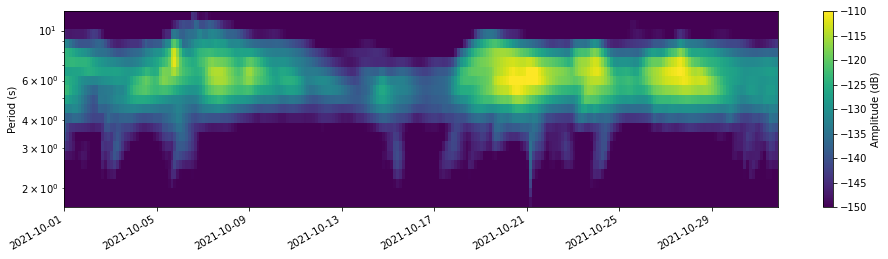

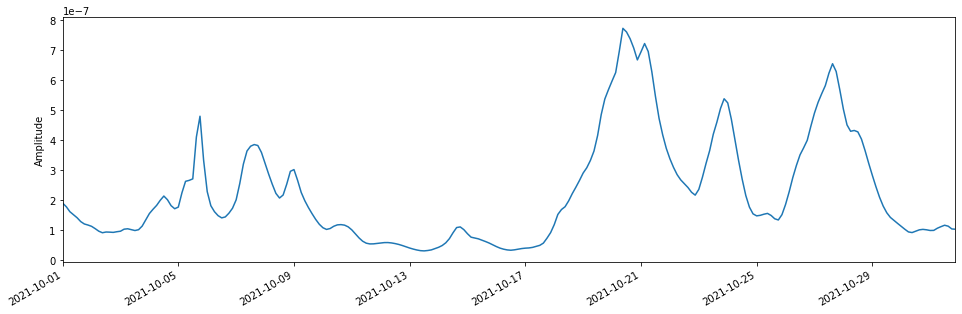

In [13]:
fig = plt.figure(figsize=(16,4), facecolor="w")
cmap = plt.get_cmap('viridis')
psd = 10* np.log10(dfF_fs)
plt.pcolormesh(dfF_fs.columns, 1./dfF_fs.index, psd, cmap=cmap, vmin = -150, vmax =-110)
plt.colorbar().set_label("Amplitude (dB)")
plt.ylabel("Period (s)")
plt.yscale('log')
fig.autofmt_xdate()
#plt.ylim(10e-2,10e2)
plt.show()


fig = plt.figure(figsize=(16,5), facecolor="w")
integ = np.sqrt(scipy.integrate.trapz(dfF_fs.fillna(0), dfF_fs.index, axis=0))
plt.plot(dfF_fs.columns, integ)
plt.ylabel("Amplitude")
fig.autofmt_xdate()
plt.xlim(dfF_fs.columns[0],dfF_fs.columns[-1])
plt.show()